In [1]:
import numpy as np
import numpy.linalg as la
import numpy.random as rand
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint


In [2]:
# Rossler System
def Rossler(xi, t):
    a = 0.2
    b = 0.2
    c = 5.7
    
    (x,y,z) = xi

    dx = -y - z
    dy = x + a * y
    dz = b + z * ( x - c )

    return np.array( [dx,dy,dz] )

def RosslerP(xi, t, a, b, c):    
    (x,y,z) = xi

    dx = -y - z
    dy = x + a * y
    dz = b + z * ( x - c )

    return np.array( [dx,dy,dz] )

def Lorenz(xi,t):
    rho = 25.0
    sigma = 10.0
    beta = 8.0 / 3.0
    
    (x,y,z) = xi
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

def LorenzP(xi,t, rho, sigma, beta):
    
    (x,y,z) = xi
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

def Lorenz96(x, t):
    N = 5 # dimension
    F = 8

    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return d    

def LorenzYang(xi, t):
    k1 = lambda t : -0.01*(t**2)
    k2 = lambda t : 0.01*t
    k3 = lambda t : 0.01*t
    k4 = lambda t : -0.01*(t ** 2)

    rho = 28.0
    sigma = 10.0
    beta = 8.0 / 3.0
    
    (x,y,z) = xi
    return -sigma*(x-y)+k1(t)*y, rho*x-y-x*z+k2(t)*z, -beta*z+x*y+(k3(t)+k4(t))*y  # Derivatives

In [3]:
def delayEmbed(Xin, Yin,assignment,embInterval):
    
    tmplen = Xin.shape[1]

    tmp = np.zeros([sum(x) for x in zip(Xin.shape,(0,sum(assignment)))])
    tmp[:,:Xin.shape[1]] = Xin
    Xin = tmp

    lag = 1
    newColInd = 0
    if len(assignment) != tmplen:
        print("Assigment list doesn't match the number of variables in data array! ",assignment)
        return
    else:
        # code that creates the lags
        for i in range(len(assignment)):
            for _ in range(assignment[i]):
                newCol = Xin[:-embInterval*lag,i]
                Xin[embInterval*lag:, tmplen + newColInd] = newCol
                newColInd += 1
                lag += 1
    Xin = Xin[embInterval*sum(assignment):]
    Yin = Yin[embInterval*sum(assignment):]
    
    # Yin = Yin[-X.shape[0]:]
    
    return (Xin, Yin)

# embedd with tuple of all variables as if each were a single variable
def delayEmbedUnitary(Xin, Yin, eD, eI):
    # eD - embedding dimension, eI - embedding Interval
    n = Xin.shape[0]
    
    if Xin.ndim == 1: # make sure flattened arrays are given 1 width dimension
        p = 1
        Xin = Xin.reshape((n,1))
    else:
        p = Xin.shape[1]
        
    Xout = np.zeros((n-eD*eI, p*(1+eD)))
    for ed in range(eD+1):
        Xout[:,ed*p:(ed+1)*p] = Xin[ed*eI:n-(eD-ed)*eI]
    Yout = Yin[eD*eI:]
    return (Xout, Yout)

In [42]:
end = 2**6
tlen = 2**10
print("Stepsize = {st}".format(st=end/tlen))
trainToTest = 0.5 # between 0 and 1
t = np.linspace(0, end, num=tlen)

# MAKE SURE TO UPDATE THE DIMENSION WHEN SWITCHING ATTRACTORS
dim = 3
# t0 = np.array([0.5])
t0 = np.ones(dim) * 0.3333 # np.array([0,5,15]) * 1 # np.zeros(dim)
t0[0] += 0.1

Stepsize = 0.0625


In [43]:
# STATIONARY SIMULATION VERSION: UPDATE ATTRACTOR YOU WANT HERE
#               \/\/\/\/
# Xr = odeint(Lorenz,t0,t)

# NON STATIONARY VERSION


# Lorenz
rho = lambda t : 28 + 4 * np.sin( 4 * 2 *np.pi * t / (tlen-2))# (2*np.heaviside(t-500, 1)-np.heaviside(t-1000, 1)) # rho = 28.0
# sigma = 10       # sigma = 10.0
sigma = lambda t : 10.0 # np.sin( 4 * 2*np.pi * t / (tlen-2))
beta = lambda t : 8.0 / 3.0  # beta = 8.0 / 3.0

largs = lambda t : (rho(t), sigma(t), beta(t))

states = np.zeros((tlen,3))
states[0] = t0
for i in range(1, tlen ):
    # print(largs(i))
    states[i] = odeint(LorenzP,states[i-1],np.array([t[i-1],t[i]]),args=largs(i))[1,:]
Xr = states
"""

# Rossler
ap = lambda t : 0.2 + 0.1 * np.sin( 4 * 2*np.pi * t / (tlen-2)) # (2*np.heaviside(t-500, 1)-np.heaviside(t-1000, 1)) # rho = 28.0
# sigma = 10       # sigma = 10.0
bp = lambda t : 0.2 # np.sin( 4 * 2*np.pi * t / (tlen-2))
cp = lambda t : 5.7 # beta = 8.0 / 3.0

largs = lambda t : (ap(t), bp(t), cp(t))

states = np.zeros((tlen,3))
states[0] = t0
for i in range(1, tlen ):
    # print(largs(i))
    states[i] = odeint(RosslerP,states[i-1],t[i-1:i+1],args=largs(i))[1,:]
Xr = states
"""
# END NON STATIONARY

'\n\n# Rossler\nap = lambda t : 0.2 + 0.1 * np.sin( 4 * 2*np.pi * t / (tlen-2)) # (2*np.heaviside(t-500, 1)-np.heaviside(t-1000, 1)) # rho = 28.0\n# sigma = 10       # sigma = 10.0\nbp = lambda t : 0.2 # np.sin( 4 * 2*np.pi * t / (tlen-2))\ncp = lambda t : 5.7 # beta = 8.0 / 3.0\n\nlargs = lambda t : (ap(t), bp(t), cp(t))\n\nstates = np.zeros((tlen,3))\nstates[0] = t0\nfor i in range(1, tlen ):\n    # print(largs(i))\n    states[i] = odeint(RosslerP,states[i-1],t[i-1:i+1],args=largs(i))[1,:]\nXr = states\n'

In [44]:
# Logistic Map
"""
r = lambda t : 3.8 # + 0.6 * np.sin(4*2*np.pi*t/tlen)
# r = lambda t : 0.5 * t / tlen + 3.5
states = np.zeros((tlen,1))
states[0,0] = t0
for t in range(1,tlen):
    states[t,0] = r(t) * states[t-1,0] * (1 - states[t-1,0])
Xr = states


# Density Dependent Maturation
states = np.ones((tlen, 2))
s = 0.02
gamma = 0.01
sA = 0.1
sJ = 0.5
b = 35
# Gmax = 0.9
# g = lambda x : Gmax*np.exp(-gamma*x)
# Gmax = lambda t : 0.25 + t * 0.74 / (tlen-2) # LINEAR GMAX
# Gmax = lambda t : 0.75 + 0.25 * np.sin( 4 * 2 * np.pi * t / (tlen-2)) # PERIODIC
Gmax = lambda t : 0.75
g = lambda x , t: Gmax(t)*np.exp(-gamma*x)
states[0] = np.array([5,300])
for i in range(0,tlen-1):
    At = states[i,0]
    Jt = states[i,1]
    zt = rand.normal(-s/2, s) # rand.normal(0,s) # vs rand.normal(-(s**2)/2, s)
    # m = np.array([[sA, sJ*g(At+Jt)],[b*np.exp(zt), sJ*(1-g(At+Jt))]])
    m = np.array([[sA, sJ*g(At+Jt,i)],[b*np.exp(zt), sJ*(1-g(At+Jt,i))]])
    states[i+1] = m @ states[i].T
Xr = states
"""

'\nr = lambda t : 3.8 # + 0.6 * np.sin(4*2*np.pi*t/tlen)\n# r = lambda t : 0.5 * t / tlen + 3.5\nstates = np.zeros((tlen,1))\nstates[0,0] = t0\nfor t in range(1,tlen):\n    states[t,0] = r(t) * states[t-1,0] * (1 - states[t-1,0])\nXr = states\n\n\n# Density Dependent Maturation\nstates = np.ones((tlen, 2))\ns = 0.02\ngamma = 0.01\nsA = 0.1\nsJ = 0.5\nb = 35\n# Gmax = 0.9\n# g = lambda x : Gmax*np.exp(-gamma*x)\n# Gmax = lambda t : 0.25 + t * 0.74 / (tlen-2) # LINEAR GMAX\n# Gmax = lambda t : 0.75 + 0.25 * np.sin( 4 * 2 * np.pi * t / (tlen-2)) # PERIODIC\nGmax = lambda t : 0.75\ng = lambda x , t: Gmax(t)*np.exp(-gamma*x)\nstates[0] = np.array([5,300])\nfor i in range(0,tlen-1):\n    At = states[i,0]\n    Jt = states[i,1]\n    zt = rand.normal(-s/2, s) # rand.normal(0,s) # vs rand.normal(-(s**2)/2, s)\n    # m = np.array([[sA, sJ*g(At+Jt)],[b*np.exp(zt), sJ*(1-g(At+Jt))]])\n    m = np.array([[sA, sJ*g(At+Jt,i)],[b*np.exp(zt), sJ*(1-g(At+Jt,i))]])\n    states[i+1] = m @ states[i].T\nXr = 

In [45]:
# Read input data from files
"""
file = "paramecium_didinium - cleaned.csv"
data = pd.read_csv(file,encoding="utf-8",na_filter=False)
X = data.to_numpy()
print(X)
"""

'\nfile = "paramecium_didinium - cleaned.csv"\ndata = pd.read_csv(file,encoding="utf-8",na_filter=False)\nX = data.to_numpy()\nprint(X)\n'

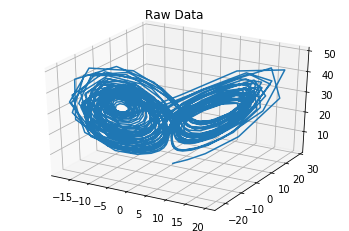

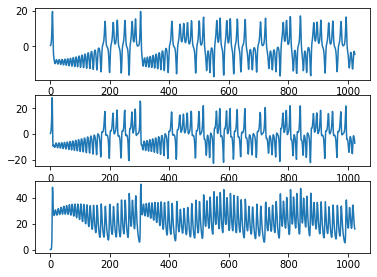

In [46]:
fig2 = plt.figure(2)
if dim == 1:
    ax2 = plt.subplot()
    ax2.plot(Xr[:,0],"b") # states
elif dim == 2:
    ax2 = plt.subplot()
    ax2.plot(Xr[:,0],Xr[:,1])
else:
    ax2 = fig2.gca(projection="3d")
    ax2.plot(Xr[:,0],Xr[:,1],Xr[:,2])
ax2.set_title("Raw Data")

""" OBSOLETE - just overembed with large step size, no need to cut things up after the fact.

figSliced = plt.figure(3)
# Sneakyness - only keep every 20th entry to test spikiness hypothesis
X = X[::]

if dim == 1:
    axSliced = plt.subplot()
    axSliced.plot(X[:,0],"b") # states
elif dim == 2:
    axSliced = plt.subplot()
    axSliced.plot(X[:,0],X[:,1])
else:
    axSliced = fig2.gca(projection="3d")
    axSliced.plot(X[:,0],X[:,1],X[:,2])
axSliced.set_title("Cut")
"""
if dim != 1:
    figTS, axTS = plt.subplots(dim,figsize=(6,dim*1.5))
    for i in range(dim):
        axTS[i].plot(Xr[:,i])

plt.show()

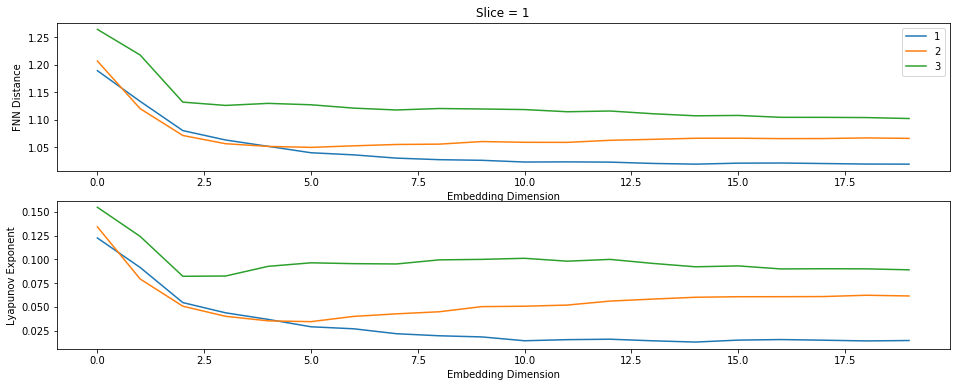

In [47]:
# False Nearest Neighbors Test
# nearest neighbor prediction code

def nearestNeighbors(s0, S, n):
    orderedNeighbors = np.argsort(la.norm(s0 - S[:-1],axis=1))
    return orderedNeighbors[1:n+1]

# Lyapunov Edition
def lyapunovExp(S):
    Lexp = 0
    n = S.shape[0]-1
    for i in range(n):
        nearNeighborsIndices = nearestNeighbors(S[i], S, 1)
        for nni in nearNeighborsIndices:
            fprime = la.norm(S[i+1] - S[nni+1]) / la.norm(S[i] - S[nni])
            Lexp += np.log(fprime) # / la.norm(S[i] - S[nni])
    return Lexp / n # geometric mean - seems like lyapunov right?

# Proper Version
def fNearestNeighbors(S, nNeighbors):
    diff = 0
    for i in range(S.shape[0]-1):
        nearNeighborsIndices = nearestNeighbors(S[i], S, nNeighbors)
        # print("S0: {s1}, NS: {s2}".format(s1=S[i],s2=S[nearNeighborsIndices]))
        for nni in nearNeighborsIndices:
            diff += la.norm(S[i+1] - S[nni+1]) / la.norm(S[i] - S[nni])
    avgDiff = diff / ((S.shape[0]-1) * nNeighbors) # geometric mean - seems like lyapunov right?
    
    return avgDiff

# print("AvgDiff = {d}".format(d=fNearestNeighbors(X,1)))

# Unitary Embedding Testing
"""
Xt = X[1:]
Y, Yt = delayEmbedUnitary(X, Xt, 2, 2)
print(X)
print(Y)
print(Yt)
"""

l = 20
c = 1
st = 4

figFNN, axFNN = plt.subplots(2 * c,figsize=(16, 3*(2*c)))

for c in range(1, c+1):
    diffs = np.zeros(l)
    lyapExps = np.zeros(l)
    for s in range(1, st, 1):
        for i in range(1, l+1):
            Y, _ = delayEmbed(Xr[::c], Xr[::c], [i]*dim,s)
            # Y, _ = delayEmbedUnitary(X, X, i,s)
            # print(Y[:3])
            d = fNearestNeighbors(Y, 1)
            diffs[i-1] = d

            lyapExps[i-1] = lyapunovExp(Y)
            # print("{I}, {J}, {K}, st {S} = {D}".format(I=i, J=i, K=i, S=s, D=d))
        axFNN[(c-1)*2].plot(diffs, label="{e}".format(e=s))
        axFNN[(c-1)*2+1].plot(lyapExps)

    axFNN[(c-1)*2].legend()
    axFNN[(c-1)*2].set_xlabel("Embedding Dimension")
    axFNN[(c-1)*2].set_ylabel("FNN Distance")
    axFNN[(c-1)*2].set_title("Slice = {ind}".format(ind=c))
    axFNN[(c-1)*2+1].set_xlabel("Embedding Dimension")
    axFNN[(c-1)*2+1].set_ylabel("Lyapunov Exponent")
    
plt.show()


In [48]:
# Slice
cut = 1
X = Xr[::cut]
tlen = np.floor(tlen / cut)

# Delay Embed
X, _ = delayEmbed(X, X, [3]*dim,1)
# X, _ = delayEmbedUnitary(X, X, 5,3) << Seems to always suck

In [49]:
# X = (X - X.mean(0) ) / X.std(0) # normalize
print(X)

[[ 2.1412 -9.5004 34.3834 ...  0.3406  0.3023  0.3333]
 [-3.1478 -8.917  29.5555 ...  0.656   0.3406  0.3023]
 [-5.7259 -8.6221 27.3274 ...  2.1429  0.656   0.3406]
 ...
 [-2.9176 -3.1523 19.697  ... 21.6952 17.6236 16.6046]
 [-3.4161 -4.7676 17.3796 ... 28.7219 21.6952 17.6236]
 [-4.6412 -7.2496 16.0898 ... 34.4153 28.7219 21.6952]]


In [50]:
"""
def lr(X,r):
    # increase the border e depending on one std distance in given dimension
    global dim 
    e = 0.5 * ((dim) ** 0.5)
    
    ind = e > la.norm(X - X[r],axis=1)
    
    neighbors = X[ind]
    neighborIndexes = np.arange(0,X.shape[0],1)[ind]
    
    l_r = np.sum(np.absolute(neighborIndexes - r)) / neighborIndexes.shape[0]
    
    return l_r
print(X.shape[0])
LR = np.zeros((X.shape[0]))
for i in range(X.shape[0]):
    LR[i] = lr(X,i)
# print(LR)

fig3 = plt.figure(3)
if dim == 1:
    ax3 = plt.subplot()
    ax3.plot(X,"b") # states
elif dim == 2:
    ax3 = plt.subplot()
    ax3.plot(X[:,0],X[:,1])
else:
    ax3 = fig2.gca(projection="3d")
    ax3.plot(X[:,0],X[:,1],X[:,2])
    
# ax3 = fig3.add_subplot(projection="3d")
# ax3.scatter(X[:,0],X[:,1],X[:,2],c="b",alpha=0.5)
lrfig = plt.figure(4)
axlr = lrfig.add_subplot(title="Lr")
axlr.plot(LR,c="y")

plt.show()
"""

'\ndef lr(X,r):\n    # increase the border e depending on one std distance in given dimension\n    global dim \n    e = 0.5 * ((dim) ** 0.5)\n    \n    ind = e > la.norm(X - X[r],axis=1)\n    \n    neighbors = X[ind]\n    neighborIndexes = np.arange(0,X.shape[0],1)[ind]\n    \n    l_r = np.sum(np.absolute(neighborIndexes - r)) / neighborIndexes.shape[0]\n    \n    return l_r\nprint(X.shape[0])\nLR = np.zeros((X.shape[0]))\nfor i in range(X.shape[0]):\n    LR[i] = lr(X,i)\n# print(LR)\n\nfig3 = plt.figure(3)\nif dim == 1:\n    ax3 = plt.subplot()\n    ax3.plot(X,"b") # states\nelif dim == 2:\n    ax3 = plt.subplot()\n    ax3.plot(X[:,0],X[:,1])\nelse:\n    ax3 = fig2.gca(projection="3d")\n    ax3.plot(X[:,0],X[:,1],X[:,2])\n    \n# ax3 = fig3.add_subplot(projection="3d")\n# ax3.scatter(X[:,0],X[:,1],X[:,2],c="b",alpha=0.5)\nlrfig = plt.figure(4)\naxlr = lrfig.add_subplot(title="Lr")\naxlr.plot(LR,c="y")\n\nplt.show()\n'

In [51]:
"""
LRsort = sorted(LR)

fig4, axLRsorted = plt.subplots(1,2)
axLRsorted[0].plot(LRsort)
axLRsorted[1].hist(LRsort)

print(np.median(LR))

plt.show()
"""

'\nLRsort = sorted(LR)\n\nfig4, axLRsorted = plt.subplots(1,2)\naxLRsorted[0].plot(LRsort)\naxLRsorted[1].hist(LRsort)\n\nprint(np.median(LR))\n\nplt.show()\n'

In [52]:
"""
def U(x, xj, k):
    return sorted(range(len(x)-1), key = lambda i : la.norm(xj - x[i]), reverse=False)[1:k+1]
"""

'\ndef U(x, xj, k):\n    return sorted(range(len(x)-1), key = lambda i : la.norm(xj - x[i]), reverse=False)[1:k+1]\n'

In [53]:
"""
# U testing
test = 100 - (np.arange(0,20,1)-10) ** 2
print(U(test,0,5), test[U(test,0,5)])

plt.plot(test)
plt.show()
"""

'\n# U testing\ntest = 100 - (np.arange(0,20,1)-10) ** 2\nprint(U(test,0,5), test[U(test,0,5)])\n\nplt.plot(test)\nplt.show()\n'

In [54]:
"""
# conditional distance
def dc(x, j, t, k):
    u = U(x, x[j], k)
    
    # print(u)
    
    D = 0
    K = k
    for l in u:
        if j+t < x.shape[0] and l+t < x.shape[0]:
            D += la.norm(x[j+t] - x[l+t])
        else:
            print("cannot access element")
            k -= 1
    
    return D / K

# neighbor distance
def d(x, j, k):
    u = U(x, x[j], k)
    
    D = 0
    for l in u:
        D += la.norm(x[j] - x[l])
    
    return D / k
"""

'\n# conditional distance\ndef dc(x, j, t, k):\n    u = U(x, x[j], k)\n    \n    # print(u)\n    \n    D = 0\n    K = k\n    for l in u:\n        if j+t < x.shape[0] and l+t < x.shape[0]:\n            D += la.norm(x[j+t] - x[l+t])\n        else:\n            print("cannot access element")\n            k -= 1\n    \n    return D / K\n\n# neighbor distance\ndef d(x, j, k):\n    u = U(x, x[j], k)\n    \n    D = 0\n    for l in u:\n        D += la.norm(x[j] - x[l])\n    \n    return D / k\n'

In [55]:
"""
# distance tests
print(test[U(test,test[0],5)])
print(d(test, 0, 5))
print(dc(test, 0, 2, 5))

unif = np.ones(50)
print(d(unif, 4, 10))
print(dc(unif, 4, 5, 10))
"""

'\n# distance tests\nprint(test[U(test,test[0],5)])\nprint(d(test, 0, 5))\nprint(dc(test, 0, 2, 5))\n\nunif = np.ones(50)\nprint(d(unif, 4, 10))\nprint(dc(unif, 4, 5, 10))\n'

In [56]:
"""
# dynamic similarity
def S(x, j, t, k):
    return d(x, j, k) / dc(x, j, t, k)
"""

'\n# dynamic similarity\ndef S(x, j, t, k):\n    return d(x, j, k) / dc(x, j, t, k)\n'

In [57]:
"""
s = np.zeros(test.shape[0])
for i in range(len(s)):
    s[i] = S(test, i, 1, 1)
    
plt.plot(s)
plt.show()
"""

'\ns = np.zeros(test.shape[0])\nfor i in range(len(s)):\n    s[i] = S(test, i, 1, 1)\n    \nplt.plot(s)\nplt.show()\n'

In [58]:
"""
def flus(x, k, low, upp):
    s = np.zeros(upp-low)
    for i in range(low,upp):
        s[i-low] = S(x, i, 1, k)
    
    mus = sum(s) / (upp - low)
    
    fl = sum( (s-mus)**2 )
    return fl
"""

'\ndef flus(x, k, low, upp):\n    s = np.zeros(upp-low)\n    for i in range(low,upp):\n        s[i-low] = S(x, i, 1, k)\n    \n    mus = sum(s) / (upp - low)\n    \n    fl = sum( (s-mus)**2 )\n    return fl\n'

In [59]:
"""
print(flus(X, 5, 0, 19))
winSize = 100

FlucOfSim = np.zeros(tlen - winSize)
for i in range(FlucOfSim.shape[0]):
    FlucOfSim[i] = flus(X, 20, i, i+winSize)
    print(FlucOfSim[i])
"""

'\nprint(flus(X, 5, 0, 19))\nwinSize = 100\n\nFlucOfSim = np.zeros(tlen - winSize)\nfor i in range(FlucOfSim.shape[0]):\n    FlucOfSim[i] = flus(X, 20, i, i+winSize)\n    print(FlucOfSim[i])\n'

In [60]:
"""
fig, axs = plt.subplots(2,1)

axs[0].plot(X)
axs[1].plot(FlucOfSim)
plt.show()
"""

'\nfig, axs = plt.subplots(2,1)\n\naxs[0].plot(X)\naxs[1].plot(FlucOfSim)\nplt.show()\n'

In [61]:
# Slow Feature Analysis

def hprime(x):
    n = x.shape[0]
    d = x.shape[1]
    
    M = int(d+d*(d+1)/2) # number of monomials and binomials
    
    hx = np.zeros((n,M))
    hx[:,0:d] = x
    ind = d
    for i in range(d):
        xi = x[:,i]
        for j in range(i,d):
            xj = x[:,j]
            hx[:,ind] = np.multiply(xi, xj)
            ind += 1
            
    return hx

def standardize(x):
    return (x - np.mean(x, axis=0)) # / np.std(x, axis=0)

In [62]:
np.set_printoptions(precision=4, suppress=True)
# print("X = ", X.shape)
Xst = standardize(X)
# print(Xst.shape, hp.shape)
# zprime = Xst
zprime = hprime(Xst)
c = np.cov(zprime.T, bias=False)
# print("Covariance = ", c, c.shape)

eigval, eigvec = la.eigh(c)
# print("Eigenstuff = ", eigval, eigvec)
print("Eigenvals(shouldn't be near 0) ", eigval)

diagEigVal = np.diag((eigval+1e-10) ** -0.5)

# print(zprime.shape, diagEigVal.shape, eigvec.T.shape)
z = zprime @ (eigvec @ diagEigVal)
# print("z = ", z)
print("Mean test(should be 0)", np.mean(z))
print("Covariance test(should be I): \n",np.cov(z.T))

Eigenvals(shouldn't be near 0)  [     0.          0.          0.          0.          0.          0.
      0.          0.0003      0.0003      0.0005      0.0006      0.0008
      0.0011      0.0015      0.0018      0.0024      0.0032      0.0045
      0.0063      0.0116      0.0152      0.0175      0.0185      0.0379
      0.04        0.0531      0.0666      0.069       0.1148      0.1373
      0.1837      0.2185      0.3011      0.3095      0.5282      0.6013
      0.7567      0.8208      1.0253      1.5807      1.734       2.1444
      2.4163      2.4433      3.966       4.979       5.4645      6.2271
      6.9043     12.6875     14.6205     15.6376     22.3697     26.3383
     30.2619     36.5072     39.8783     52.714      68.3183     87.5658
     95.3241    118.2542    163.7963    218.9625    235.4613    269.0685
    369.1313    555.7474    626.9823    938.4905    965.7175   1151.6753
   1375.2782   2215.17     2875.5193   3234.6794   4012.906    4623.0707
   5964.4176   6967.599

In [63]:
zdot = z[1:,:] - z[:-1,:]

# print((zdot @ zdot.T).round(4))
covzdot = np.cov(zdot.T)
# print(covzdot.shape)
eigValDot, eigVecDot = la.eigh(covzdot)
print("EigenVectors = ", eigVecDot)
print(eigValDot)

a = eigVecDot[:,np.argsort(eigValDot)[0]] # eigVecDot.sort(key=eigValDot)[0]
print(a)
yt = a @ z.T
print(a.shape, z.shape)

EigenVectors =  [[ 0.0013 -0.0216 -0.0067 ...  0.0165 -0.0026  0.0108]
 [-0.0054  0.0023 -0.0099 ...  0.0266  0.02   -0.0037]
 [ 0.0052 -0.0077  0.0069 ... -0.0803 -0.0238  0.0073]
 ...
 [-0.287  -0.244  -0.1176 ...  0.0042 -0.0023 -0.0036]
 [-0.2139 -0.0525 -0.3209 ...  0.0011  0.0023 -0.0005]
 [ 0.116  -0.0883  0.3795 ... -0.0029  0.0021 -0.0019]]
[0.0023 0.0114 0.0248 0.0286 0.0385 0.0481 0.0678 0.1188 0.1235 0.1477
 0.1548 0.1885 0.1983 0.2132 0.2433 0.2504 0.2694 0.2872 0.3087 0.3428
 0.3647 0.3775 0.4102 0.4251 0.4529 0.4624 0.504  0.5371 0.5561 0.5956
 0.6879 0.7239 0.7379 0.7627 0.8247 0.8448 0.8766 0.9416 0.9552 0.9868
 1.0716 1.1152 1.1268 1.1607 1.2085 1.273  1.3231 1.3596 1.3707 1.4573
 1.5074 1.5372 1.5845 1.6218 1.733  1.8085 1.8545 1.856  1.9638 2.0266
 2.048  2.1013 2.1199 2.2006 2.2688 2.3064 2.3071 2.3495 2.4373 2.5222
 2.6076 2.6696 2.6885 2.8295 2.923  2.936  2.966  3.0186 3.1688 3.2627
 3.3323 3.3955 3.4622 3.5544 3.6646 3.7083 3.7297 3.8468 3.9034 3.9327]
[ 0.0013

[28.     28.0984 28.1967 ... 27.0262 27.1219 27.2181]
Differences = [26.6475 28.1844 28.5885]


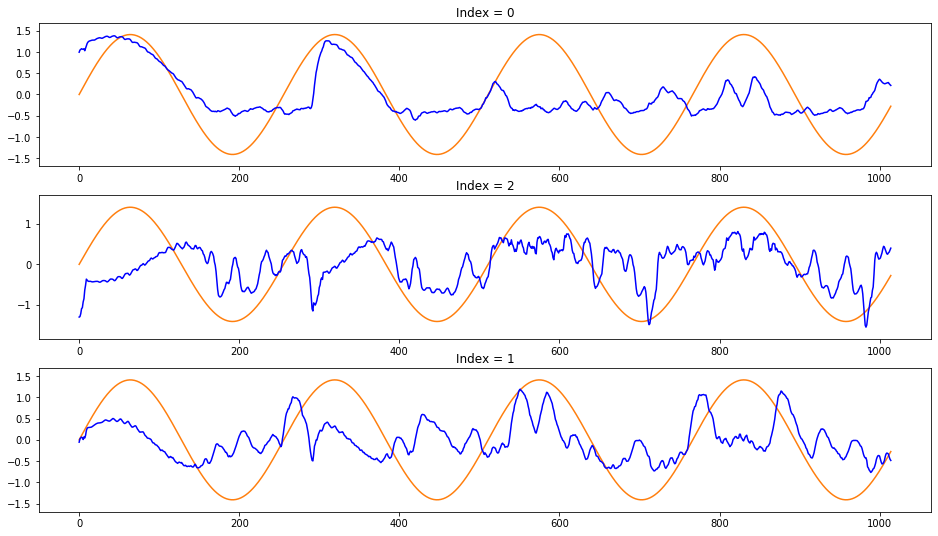

In [65]:
# Idea - write function that check similarity between true and SFA'd time series

gts = np.fromfunction(lambda i : rho(i/cut), yt.shape , dtype = float)# time series of gmax
print(gts)
cutoff = 5000

nVec = z.shape[1]
gtsStnd = (gts - np.mean(gts)) / np.std(gts)

diffs = np.zeros(nVec)

for e in range(nVec):
    ae = eigVecDot[:,np.argsort(eigValDot)[e]] @ z.T
    aeStnd = ae - np.mean(ae)
    aeStnd = aeStnd / la.norm(aeStnd)
    delta = gtsStnd @ aeStnd.T
    aeScld = aeStnd * delta
    
    diffs[e] = la.norm(gtsStnd - aeScld)
    # print(delta)

K = 3
figSim, axSim = plt.subplots(K,figsize=(16,K*3))
diffSrtd = np.argsort(diffs)
print('Differences = {d}'.format(d=diffs[diffSrtd[:3]]))
for k in range(K):
    e = diffSrtd[k]
    
    ae = eigVecDot[:,np.argsort(eigValDot)[e]] @ z.T
    aeStnd = ae - np.mean(ae)
    aeStnd = aeStnd / la.norm(aeStnd)
    delta = gtsStnd @ aeStnd.T
    aeScld = aeStnd * delta
    
    D = la.norm(gtsStnd - aeScld)
    
    axSim[k].margins(y=0.1)
    axSim[k].plot(gtsStnd[:cutoff],c="tab:orange")
    axSim[k].plot(aeScld[:cutoff],c="b")
    # axSim[k].legend("Diff = {dif}".format(dif=D), loc=1)
    axSim[k].set_title("Index = {ind}".format(ind=e))

plt.subplots_adjust(hspace=0.2)
plt.show()

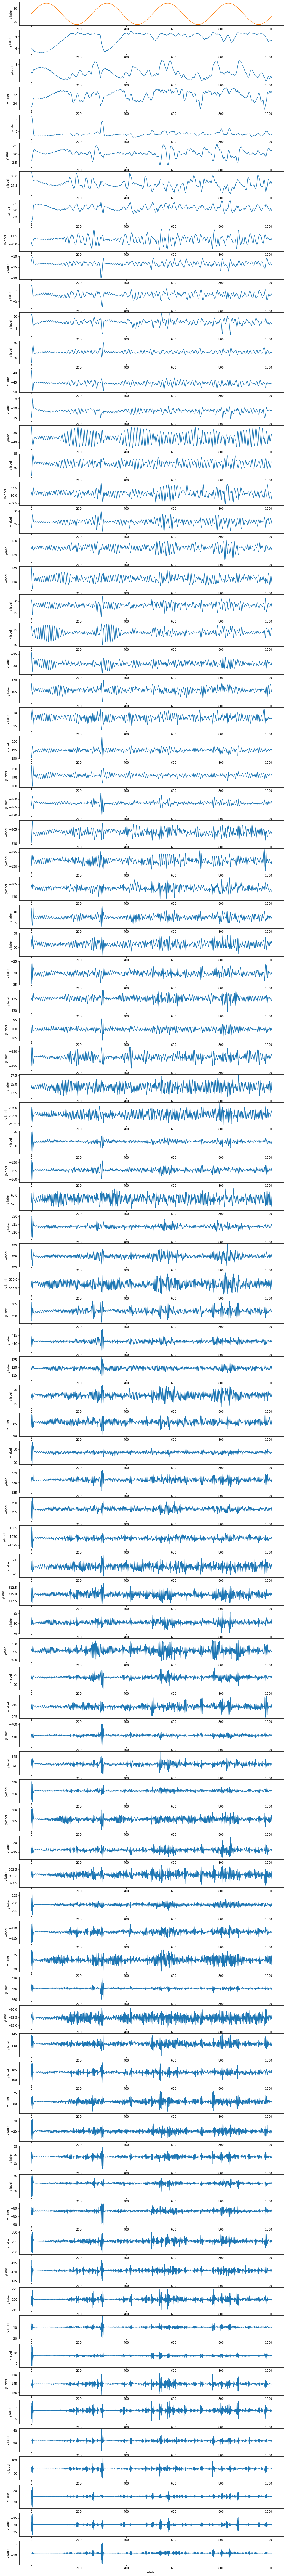

In [66]:
# gts = np.fromfunction(lambda i : r(i), yt.shape, dtype = float)# time series of gmax

# gts = np.fromfunction(lambda i : Gmax(i), yt.shape, dtype = float)# time series of gmax
# gts = np.fromfunction(lambda i : rho(i), yt.shape , dtype = float)# time series of gmax

cutoff = 5000
E = len(eigValDot)
fig, axs = plt.subplots(E+1,figsize=(16,(E+1)*1.75))
axs[0].plot(gts[:cutoff], c="tab:orange")

# print(ae.shape, z.T.shape)
for e in range(E):
    ae = eigVecDot[:,np.argsort(eigValDot)[e]]
    axs[e+1].plot((ae @ z.T)[:cutoff])

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# plt.plot(yt)

"""
# Zoom in on two
specInd = 4
figZ, axZ = plt.subplots(2, figsize=(16,6))
axZ[0].plot(gts[:200,], c="tab:orange")
ae = eigVecDot[:,np.argsort(eigValDot)[specInd]]
axZ[1].plot((ae @ z.T)[:200,])
"""

plt.show()

In [ ]:
expCov = np.array([[1, 0.1, 0.9],[0.1, 1, 0.2],[0.9, 0.2, 1]])
print(expCov)
expVal, expVec = la.eigh(expCov)
print("Eigenvalues ", expVal)
print("Eigenvectors \n", expVec)

scaledVec = expVec * expVal
print(scaledVec, scaledVec[:,0])

covAx = plt.figure().add_subplot(projection="3d")
covAx.axes.set_xlim3d(left=-3,right=3)
covAx.axes.set_ylim3d(bottom=-3,top=3)
covAx.axes.set_zlim3d(bottom=-3,top=3)
covAx.quiver(np.zeros((3)),np.zeros((3)),np.zeros((3)), scaledVec[:,0], scaledVec[:,1], scaledVec[:,2], normalize=False)
plt.show()